# Understanding graduate admissions - Data driven advice for undergrad students 

- toc: true 
- badges: true
- comments: true
- author: Mehul Jain
- categories: [machine_learning, data_science]

What are the most important things in your masters application? How do you get into your dream institute? Is my GRE score enough? How much does CGPA matter?

These are questions that I have been obsessed with recently. If you are planning to go for Masters you know what I am talking about. In this blog post, I have tried my best to answer the above questions. But, there is a twist. I am going to use a data driven approach to answer the questions instead of citing online resources and personal anecdotes. 

So let's dive into it!

## Downloading dataset from Kaggle

This blog post is built using Google Colab. It is a notebook server provided by Google for free. You can also use other services to run the code below but you will have to figure out how to get the dataset. The dataset that we use here is present on Kaggle and you can directly download it from [here](https://www.kaggle.com/mohansacharya/graduate-admissions/version/2?select=Admission_Predict_Ver1.1.csv).

In this notebook, we are going to download the dataset from Kaggle into Google Colab and store it in a directory in our Google Drive. Storing your data in the Drive saves you from the trouble of downloading the dataset every time you start a new session  in Colab. 

For further guidance read this wonderful article by Mrinali Gupta: [How to fetch Kaggle Datasets into Google Colab](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)

So let's get to it!

First, we need to mount our google drive so that we can access all the folders in the drive. 

In [ ]:
#collapse-output
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Then we will using the following code to provide a config path for the Kaggle Json API

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/GraduateAdmissions"

We will change our current directory to where we want the dataset to be downloaded 

In [ ]:
%cd /content/gdrive/My Drive/kaggle/GraduateAdmissions

/content/gdrive/My Drive/kaggle/GraduateAdmissions


Now we can download the dataset from kaggle

In [ ]:
!kaggle datasets download -d mohansacharya/graduate-admissions

  0% 0.00/9.64k [00:00<?, ?B/s]
100% 9.64k/9.64k [00:00<00:00, 1.33MB/s]


Let's unzip the files

In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  graduate-admissions.zip
  inflating: Admission_Predict.csv   
  inflating: Admission_Predict_Ver1.1.csv  


What files are present in the current directory?

In [ ]:
!ls

Admission_Predict.csv  Admission_Predict_Ver1.1.csv  kaggle.json


Our directory has a file named 'Admission_Predict_Ver1.1.csv'. That is our dataset. After we have downloaded our dataset, we have to install some important python libraries. 

In [ ]:
#collapse-output
! [ -e /content ] && pip install -Uqq fastai dtreeviz

Now that our initial setup is done, let's see what our data looks like.  

## Understanding our dataset



Before going forward, let's import the essential python libraries. 

In [ ]:
#collapse-hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from fastai.tabular.all import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error
from sklearn.inspection import plot_partial_dependence
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Our dataset contains information about the profiles of 500 students who have applied to different colleges for their masters. Each row in the dataset contains information about the different parameters that are used by the universities to judge the merit of a candidate.

Let's take a look at our data.

In [ ]:
df=pd.read_csv('Admission_Predict_Ver1.1.csv')
df.head(20)

,Serial No.,GRE Score,TOEFL Score,University Rating,...,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,...,4.5,9.65,1,0.92
1,2,324,107,4,...,4.5,8.87,1,0.76
2,3,316,104,3,...,3.5,8.00,1,0.72
3,4,322,110,3,...,2.5,8.67,1,0.80
4,5,314,103,2,...,3.0,8.21,0,0.65
5,6,330,115,5,...,3.0,9.34,1,0.90
6,7,321,109,3,...,4.0,8.20,1,0.75
7,8,308,101,2,...,4.0,7.90,0,0.68
8,9,302,102,1,...,1.5,8.00,0,0.50
9,10,323,108,3,...,3.0,8.60,0,0.45


**So, what are the parameters used by universities to judge the merit of a candidate?** <br>In this dataset, we have 6 important parameters that influence the selection of a candidate:
 1.   **GRE Score** - Your official GRE score         
 2.   **TOEFL Score** - Your official TOEFL score         
 3.   **SOP   (Statement of Purpose)** - The rating of your SOP on a scale of 1-5          
 4.   **LOR    (Letter of Recommendation)** - The rating of your LOR on a scale of 1-5        
 5.   **CGPA** - Your CGPA              
 6.   **Research** - Whether you have done some research or not (True or False)         

Now, obviously there are many more things that can influence your selection in a particular university. But, these are the bare essentials you need for applying to any graduate program. We also have a 'University Rating' column which represents how good a college is on the scale of 1 to 5. Another important column is the 'Chance of Admit', this column shows the probability of a student to get accepted in the institution he/she applied to.    

Let's look at the kind of information each column contains.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


All the columns contain numeric information with int or float types. There are no columns in the dataset containing string or other types of information. We should also look at the number of unique values in each column to further understand our data. 

In [ ]:
df.nunique()

Serial No.           500
GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 184
Research               2
Chance of Admit       61
dtype: int64

From above, we can see that the 'Research' column contains only two values (0 and 1). This means that it is a boolean column. It does not provide us information about the kind of research done or the quantity of research done, it just tells us whether a student has done some research or not.

We can also see that the 'Serial No.' column can be dropped since it does not provide any useful information about a candidate's profile.

In [ ]:
df.drop(columns=['Serial No.'],inplace=True)

We have gathered some basic information about the data in our dataset. To understand our data, we need to carry out some Exploratory Data Analysis. This will help us in understanding what universities look for in a candidate, and what you must do to increase your chances of getting into your dream institute. 

## Exploratory Data Analysis 

First, let's plot scatter plots between the different parameters in our dataset and the 'Chance of Admit' column. This is a good starting point since it will let us see if their our any obvious relationships between our selected columns. 


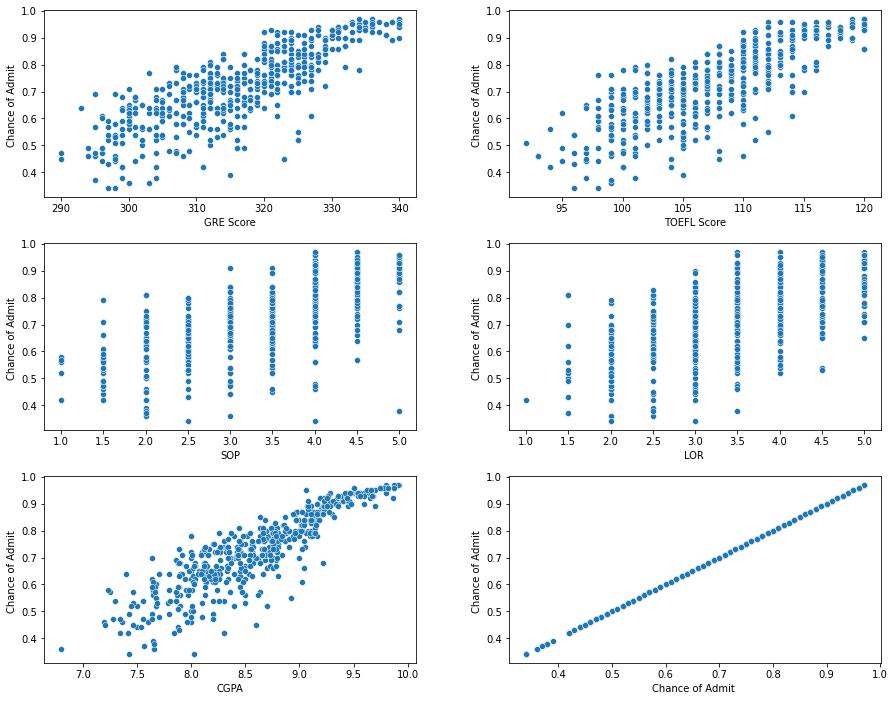

In [ ]:
scatter_plots=['GRE Score','TOEFL Score','SOP','LOR ','CGPA','Chance of Admit ']
fig=plt.figure()
fig.set_size_inches(15, 12)
fig.subplots_adjust(hspace=0.25,wspace=0.25)
for i in range(len(scatter_plots)):
  ax=fig.add_subplot(3,2,i+1)
  sns.scatterplot(data=df, x=scatter_plots[i], y='Chance of Admit ') #adding kdeplots
plt.show()

From the scatter plots, we can see that there is linear relationship between the following variables:
* GRE score and Chance of Admit
* TOEFL score and Chance of Admit
* CGPA and Chance of Admit

These relationships are fairly obvious, the more you score the better your chances of admission are. But, you can also see that there are outliers who have a low chance of getting admitted despite scoring high on these tests. This tells us that the other factors also play a vital role of assessing a candidate's merit.

For parameters like SOP, LOR score, the relationship with 'Chance of Admit' looks sort of linear. Since these variables (SOP, LOR) have discrete levels, we can use a box plot to better capture their relationship with 'Chance of Admit'.

So, let's see a boxplot of SOP vs Chance of Admit.

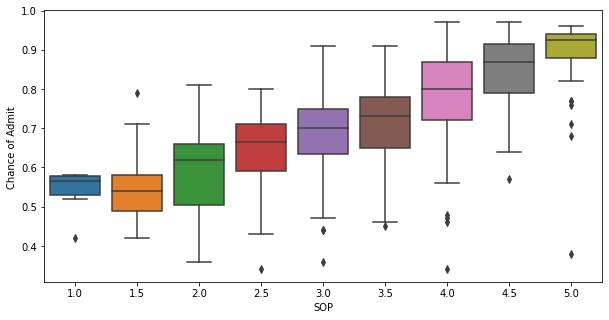

In [ ]:
fig_dims = (10,5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='SOP',y='Chance of Admit ',data=df)

This looks much better. The above boxplot tells us that a good SOP significantly affects your chances of getting admitted into your dream college. 

Now, let's look at the boxplot for LOR vs Chance of Admit. 

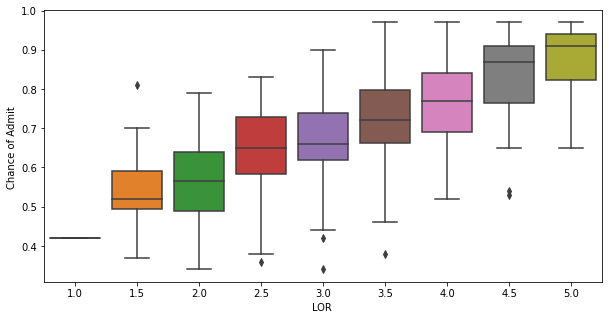

In [ ]:
fig_dims = (10,5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='LOR ',y='Chance of Admit ',data=df)

From the above boxplot, we can see how a good LOR increases your chances of getting admitted.

Finally, we can also look at the correlations between the parameters in our dataset using a heatmap. 

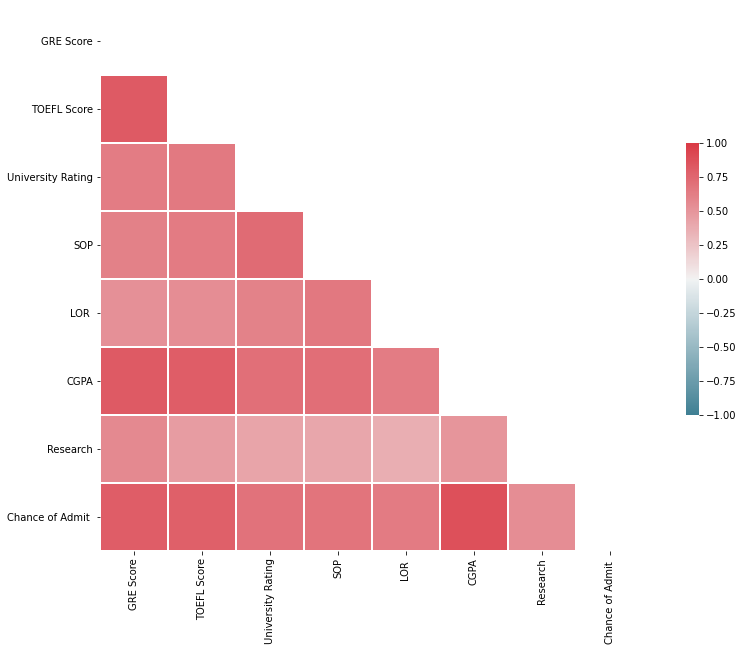

In [ ]:
correlation=df.corr()
mask=np.triu(np.ones_like(correlation,dtype=np.bool))
f,ax=plt.subplots(figsize=(15,10))
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation,mask=mask,cmap=cmap,vmax=1,vmin=-1,center=0,square=True,linewidths=.5,cbar_kws={'shrink':.5})

The above plots show that the better you perform on all these parameters, the higher your chances of getting admitted are. This can seem a very obvious thing to say, but it is important to notice that you need to be good at everything simultaneously. Just scoring high on the GRE or TOEFL won't suffice. You have to ensure that your profile is great as a whole rather than having some parts that are excellent.  

Modelling our data can be very helpful in understanding precisely how our chances of admission change. They can also help us in prioritizing things so that we can work in a focused manner. 

Let's use some machine learning to better understand graduate admissions.  

## Data Preprocessing 

Before we use machine learning to interpret our data, we need to preprocess the data to make sure it is in the right form. 

The first step is to split our data into a training set and a validation set. 



In [ ]:
dset_size=df.shape[0] # dataset size
vset_size=df.shape[0]*0.2 # validation set size
valid_idx= np.array(random.sample(range(dset_size),int(vset_size))) # validation set indices
train_idx= list(np.setdiff1d(np.arange(dset_size),valid_idx)) # training set indices 
splits=(train_idx,list(valid_idx))
dset_size,vset_size

(500, 100.0)

Then we have to apply some data processing techniques to handle our data. 

In [ ]:
procs=[Categorify,FillMissing] # applying Label Encoding and Imputation

While preprocessing our data, we have to define a dependent variable.The dependent variable is the column in our dataset whose values our ML model will predict. In this case, our dependent variable is the 'Chance of Admit' column. 

In [ ]:
dep_var='Chance of Admit '

We also have to define which columns are continuous and which are categorical. Categorical columns contain data which has discrete levels whereas data in continuous columns can have any interger or float value. 

In [ ]:
cont,cat= cont_cat_split(df,max_card=2, dep_var=dep_var)

Which are the categorical columns in our dataset?

In [ ]:
cat

['Research']

Which are the continuous columns in our dataset?

In [ ]:
cont

['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']

Let's put it all together and preprocess our data. 

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

What does our data look like now?

In [ ]:
to.show(3)

,Research,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,0.92
1,1,324,107,4,4.0,4.5,8.87,0.76
2,1,316,104,3,3.0,3.5,8.00,0.72


## Using a Decision Tree

Now that our data is ready, we will use a Decision Tree to predict the chances of admission. Decision Trees use a tree-like model of decisions with their corresponding consequences to predict the final outcome. They are very easy to interpret and often have great accuracy. As we will see, visualizing a decision tree can reveal some interesting insights. 

So,let's get the training and validation set. 

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Let's can create a decision tree.

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=20,min_samples_leaf=10,criterion='friedman_mse')
m.fit(xs, y);

Before we visualize our decision tree, we have to ensure that it fits the data reasonably well. To measure how well our model fits the data, we are going to use R2-score as our metric. R2-score ranges from 0 to 1 with 1 being the best value. 

So, what is the R2-score of our model?

In [ ]:
r2_score(valid_y,m.predict(valid_xs))

0.7820742005320787

The R2-score looks good!

Now, we will visualize the decision tree we have created. 

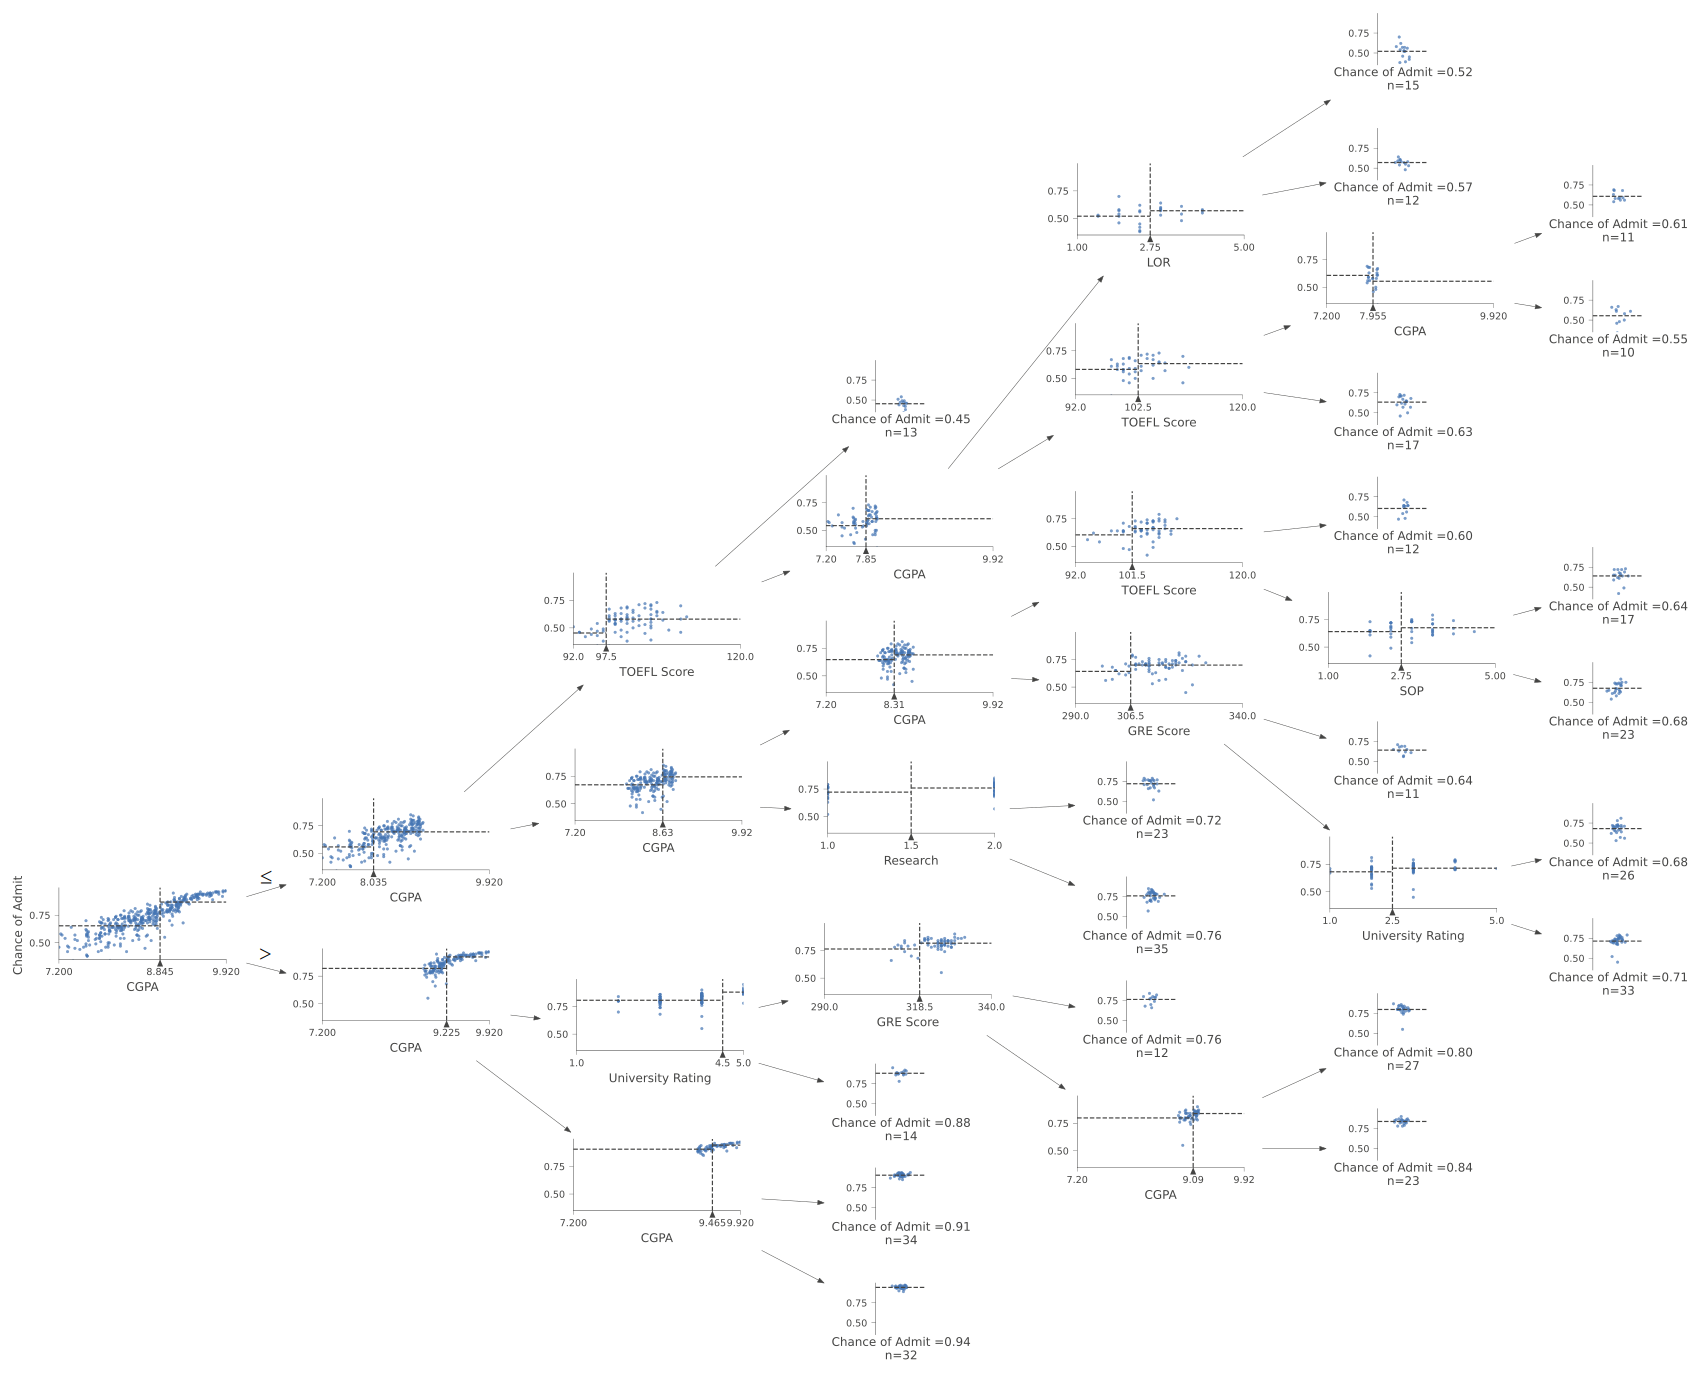

In [ ]:
dtreeviz(m, xs, y, xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

From the above visualization, we can see how our decision tree calculates the chance of admission of a student. Note that the tree will change if you use different hyperparameters for the model.

According to our decision tree, CGPA is the most important feature for distinguishing the candidates. If you follow the diagram above, you can see that having a high CGPA is a significant advantage in your graduate admissions process. 

You can also try finding the optimal hyperparameters for the above decision tree model. This will create a tree that is more specific and accurate. 

## Using a Random Forest 

Random Forest is an ensemble learning approach where multiple decision trees are used to predict the final outcome. Each tree is trained on a subset of the data and the final prediction is calculated by averaging the predictions from all the trees. Random forests are very robust and do not overfit easily. 

Like decision trees, random forests can be interpreted using various techniques that lead to deep insights about the data.

So, let's create a Random Forest.

In [ ]:
def rf(xs, y, n_estimators=100,max_features='log2', min_samples_leaf=10, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

Now, let's fit the model. 

In [ ]:
m = rf(xs, y);

As in the previous section, we will R2-score to evaluate our model.

In [ ]:
r2_score(valid_y,m.predict(valid_xs))

0.8157809694473572

We can also use other metrics (mean squared error, mean absolute error, etc) that tell us how much error our predictions have on average. Let's take a look at the mean squared error for our model. 

In [ ]:
mean_squared_error(valid_y,m.predict(valid_xs))

0.0038503179006177434

What about the mean squared log error?

In [ ]:
mean_squared_log_error(valid_y,m.predict(valid_xs))

0.00155760558458151

**Why does random forest work?**

The working of a random forest model can seem rather counterintuitive. It is not obvious why using many decision trees instead of one leads to better outcomes. But, we can verify that it does lead to better outcomes and increases accuracy.

We can stack the predictions from all the models and see how the error changes as the number of estimators (decision trees) increases.

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Let's calculate the mean squared error of the predictions while increasing the number of estimators in each iteration. 

In [ ]:
error_list=[mean_squared_error(preds[:i+1].mean(0), valid_y) for i in range(100)]

We can plot how the error changes with the number of decision trees. 

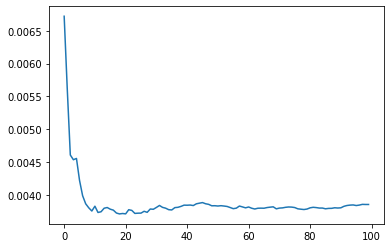

In [ ]:
plt.plot(error_list);

As we increase the number of estimators, the mean squared error dramatically decreases. This means that ensembling a number of models increases accuracy and leads to better predictions.

We can interpret our model using a number of techniques. Here, we are going to use feature importance and partial dependence plots. Feature importance tells us how important each column is for making a prediction. We can get feature importances using an inbuilt attribute of random forest model. Let's create a function to display feature importances in a proper format.  

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

So, what are our feature importances?

In [ ]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
6,CGPA,0.368737
1,GRE Score,0.268672
2,TOEFL Score,0.141553
3,University Rating,0.087964
4,SOP,0.058644
0,Research,0.042200
5,LOR,0.032229


We can plot our feature importances using a bar graph. 

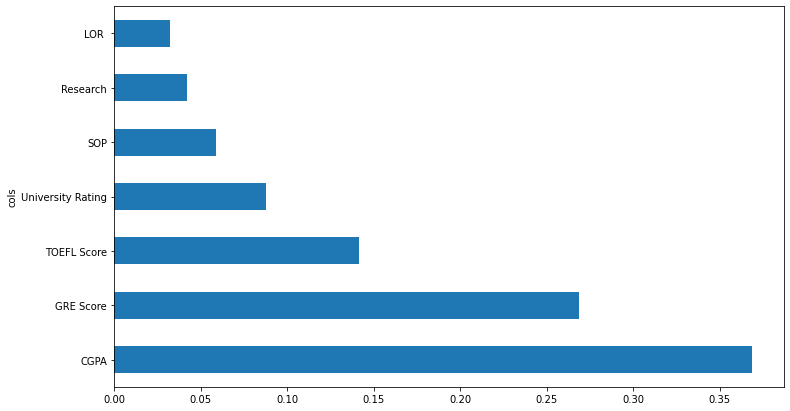

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi);

Partial Dependence Plot answers the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable? This brings out the relationship between the feature in question and the dependent variable. 

Let's see the PDPs for the top 6 features in our dataset. 

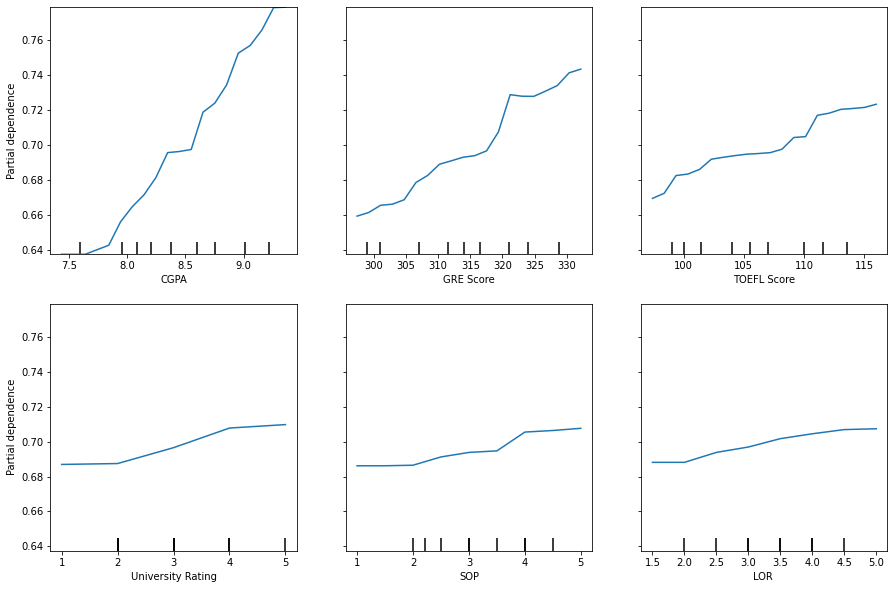

In [ ]:
stuff=list(fi.cols)
stuff.remove('Research')
fig,ax = plt.subplots(figsize=(15, 10))
plot_partial_dependence(m, valid_xs,stuff ,grid_resolution=20, ax=ax);

**What can we infer from the above visualizations?**



*   The feature importance plot tells us that the most important feature to predict the chances of admission of a candidate is the CGPA. Furthermore, the PDP for CGPA tells us that increasing the CGPA increases the chances of admission tremendously. This makes a lot of sense. If you have a high CGPA, you are presumably a great student. 
*   GRE and TOEFL score have second and third highest feature importances respectively. Again, we can see that the PDP for these features shows a similar trend as in the case of CGPA. A good score on these tests increases your chance of admission.

* Suprisingly, University Rating also affects the chance of admission. From the PDP, we see that increasing the value of University Rating increases the chance of admission. This does not make sense. It could be indicative of the bias in our data. Or, it could mean that the people who are applying to the higher ranking colleges are only applying there because they know they have a higher chance of getting admitted.

* Finally, higher ratings on the SOP and LOR also increase the chance of admission. Though, the increase is not as strong as for CGPA or GRE score, it still matters alot.



## What should you do to get into a high ranking university?

We have seen different visualizations and techniques to understand our data and gather useful insights. In this section, I will try to answer the following question using the information from our dataset: **What should you do to get into a high ranking university?**

First of all, let's seperate the profiles of students who have applied to a high ranking university ( University Rating = 4 or 5 ) and have a high chance (>80%) of getting into them. 

In [ ]:
cond= ((df['University Rating']==4) | (df['University Rating']==5)) & (df['Chance of Admit ']> .80)
ranking_idx=list(np.where(cond)[0])

Let's see how many profiles match our condition.

In [ ]:
high_rank_uni=df.iloc[ranking_idx]
high_rank_uni

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
5,330,115,5,4.5,3.0,9.34,1,0.90
11,327,111,4,4.0,4.5,9.00,1,0.84
22,328,116,5,5.0,5.0,9.50,1,0.94
23,334,119,5,5.0,4.5,9.70,1,0.95
...,...,...,...,...,...,...,...,...
482,328,113,4,4.0,2.5,8.77,1,0.83
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93


**What do they have in common?**

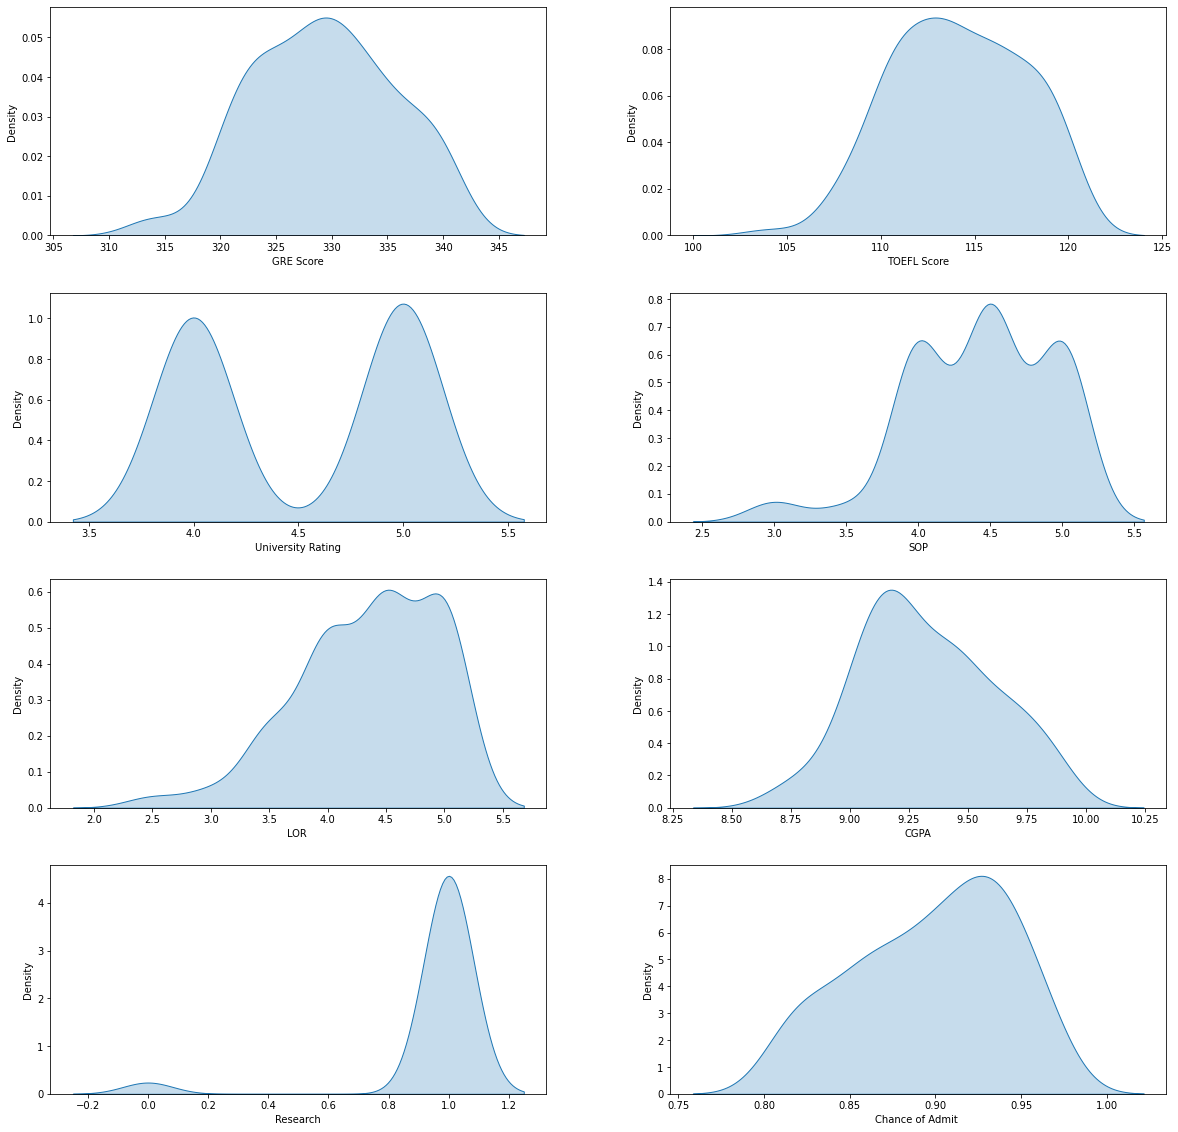

In [ ]:
fig=plt.figure()
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace=0.25,wspace=0.25)
cols=list(df.columns)
for i in range(8):
  ax=fig.add_subplot(4,2,i+1)
  sns.kdeplot(high_rank_uni[cols[i]],shade=True) #adding kdeplots
plt.show()

**Here's my advice:**

*    If you are in your second year of undergrad and still have time to save your pointer. Do it! If you are in your third year, try to boost it as much as you can. You should aim for a CGPA higher than 8.7. As I am saying this, my mind is telling me that this is an incredibly tough task. But if you accomplish it, it puts you in the group of people with high chances of getting admitted.     

*   A GRE score in the range 320 and above would be great. Most people with high chances of success fall in this range. This takes some effort and practice. But you come out with a better vocabulary and excellent reading,writing skills. 

* Getting more than 110 on the TOEFL wouldn't be a big deal for you. TOEFL is much easier than the GRE. So, you don't need to worry about it much.  

* Do some research. You need to do some research in the field you are interested in. This not only enhances your profile but prepares you for graduate school. Also, if you are not really sure about which field you want to pursue this is the perfect way to find out. 

* Finally, use your awesome writing skills to create a SOP that tells the admission committee who you really are. You might want to look online before you do anything in this regard. 



## Conclusion

Planning for graduate school is an exhausting task and requires a lot of thought. In this blog post, we have used data to understand how you can increase your chances of getting admitted into your dream institute.

My hope is that you take something valuable from this blog post and use it to accomplish your goals. If you found this helpful, please share it with your friends.

*See you on the next adventure!!!*